# Cross-species annotation
### PreProcessing (see on merge_data.ipynb)
0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill_value=0)

### Processing (this notebook)

8) Scale & PCA
9) Spearman correlation of PC to QC metrics & drop technical PC
9) Harmony integration
10) Neighbors / clustering on integrated representation
11) Compute overlap metrics (per-cluster entropy & species fractions)
12) Cross-validation evaluation (hide 20% human+mouse, majority-vote, cofusion matrix)

In [1]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Pre-processing
- Start with raw_merged data
- Filter
- Normalize
- Log transform
- Find HVG
- Combat (batch correction)

In [7]:
rev_n = 7
filename = f'/home/raquelcr/scanpy/all_adata_outer{rev_n}.h5ad'
adata = sc.read(filename)
print(f"Succesfully loaded {filename}. Shape: {adata.shape}")

Succesfully loaded /home/raquelcr/scanpy/all_adata_outer7.h5ad. Shape: (128461, 10015)


In [8]:
print(adata.shape)
print(adata.obs.columns)
print(adata.obs['dataset_name'].value_counts())

(128461, 10015)
Index(['label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type',
       'cell_supertype', 'dissection', 'region', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'tissue', 'sample_id', 'replicate', 'sample', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'total_UMIs', 'cluster_id', 'roi', 'Age',
       'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type',
       'tissue_ontology_term_id', 'cell_type_ont

### QC metrics

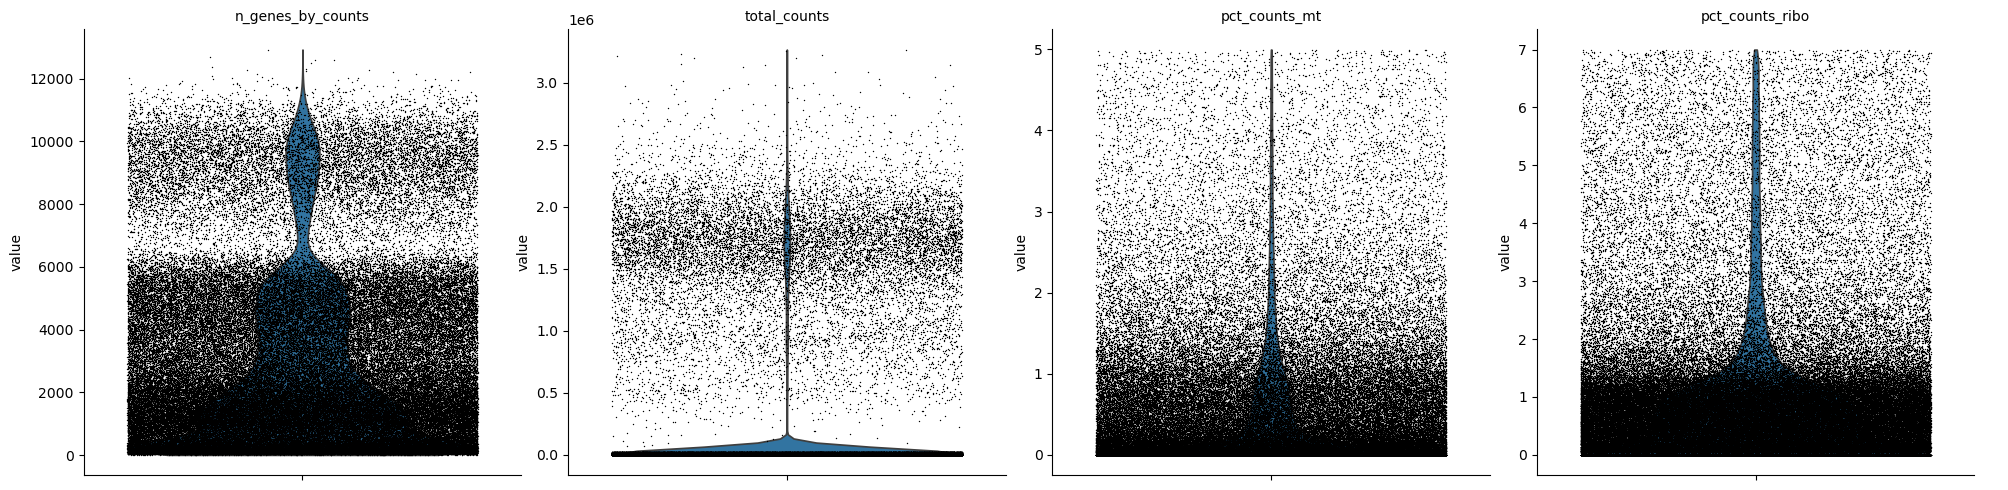

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
    jitter=0.4,
    multi_panel=True
)

### HVG

In [ ]:
#sc.pp.normalize_total(adata, exclude_highly_expressed=True, max_fraction=0.05)

In [ ]:
#sc.pp.log1p(adata)

In [ ]:
#sc.pp.highly_variable_genes(adata, n_top_genes = 5000, subset=False)

I have seen that normalization prior to harmony affects overlap, therefore we will subset the genes by the top highly variable, but avoiding to modify the adata.X

### Scale and PCA

In [21]:
sc.pp.scale(adata)
sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=False)

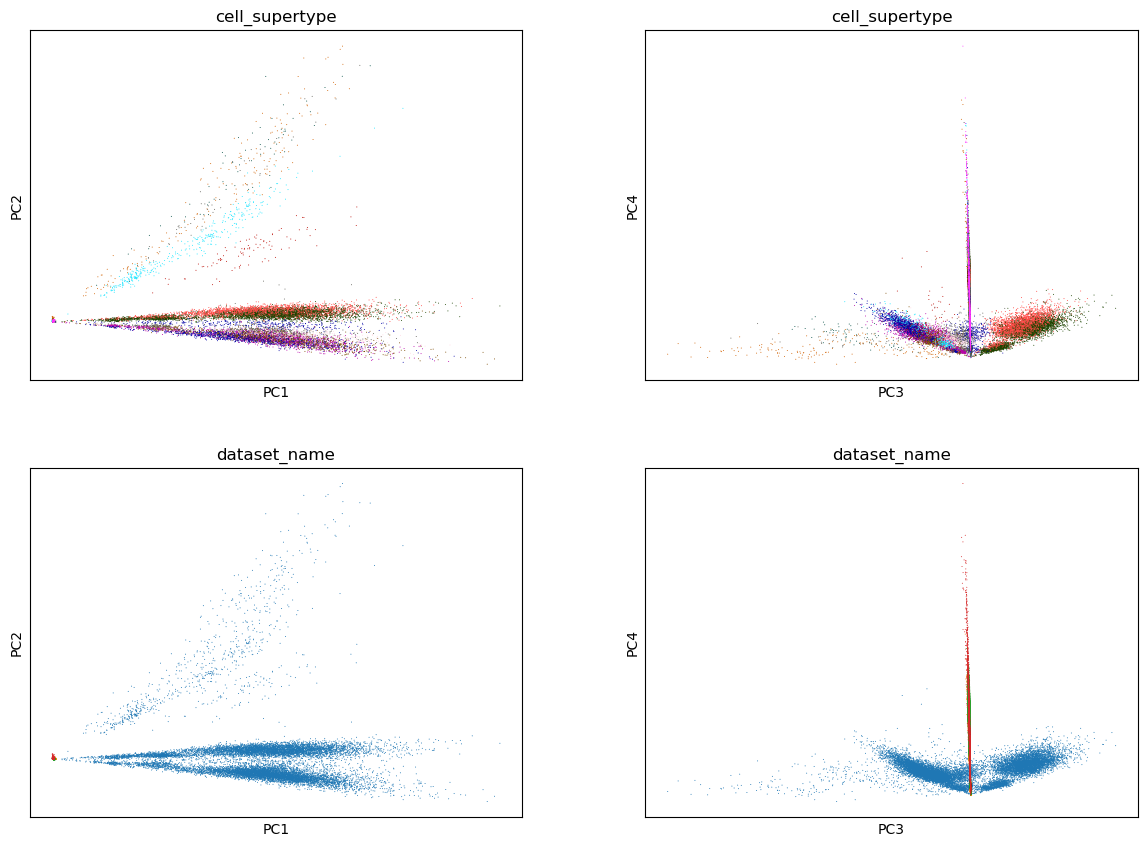

In [22]:
sc.pl.pca(
    adata,
    color=["cell_supertype","cell_supertype", "dataset_name", "dataset_name"],
    dimensions=[(0,1),(2,3), (0,1),(2,3)],
    ncols=2,
    size=2,
    save=f'_by_supertype{rev_n}.png',
    legend_loc='none' 
)

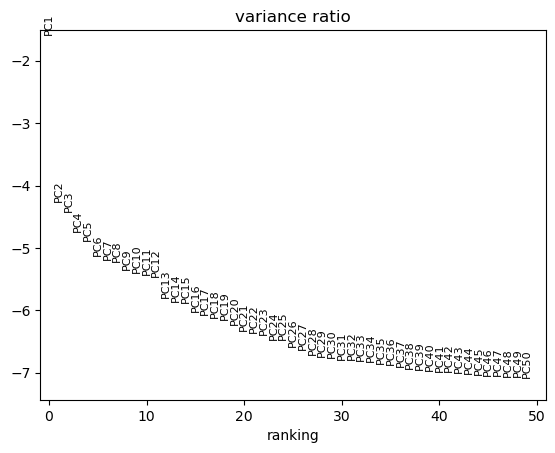

In [23]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save=f'{rev_n}.png')

In [24]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
def check_pc_correlation(adata, n_pcs=None, pc_col_name="X_pca"):
    """Check correlation between PCs and QC metrics to identify potential confounders."""
    if n_pcs is None:
        n_pcs_check = adata.obsm[pc_col_name].shape[1]
    else: n_pcs_check = min(n_pcs, adata.obsm[pc_col_name].shape[1])
    pcs = pd.DataFrame(
        adata.obsm[pc_col_name][:, :n_pcs_check],
        index=adata.obs_names,
        columns=["PC"+str(i+1).zfill(2) for i in range(n_pcs_check)]
    )

    qc_cols = ["total_counts", "n_genes_by_counts", "pct_counts_mt", 'pct_counts_ribo']
    qc = adata.obs[qc_cols].astype(float)
    qc['species'] = adata.obs['species'].astype('category').cat.codes
    qc_cols.append('species')

    rows = []
    for pc in pcs.columns:
        for cov in qc_cols:
            # Spearman es más robusto; cambia a pearsonr si prefieres lineal
            r, p = spearmanr(pcs[pc].values, qc[cov].values, nan_policy="omit")
            rows.append({"PC": pc, "covariate": cov, "r": r, "p": p})

    corr = pd.DataFrame(rows)
    corr["q"] = multipletests(corr["p"], method="fdr_bh")[1]


    return corr

In [25]:
def plot_pc_qc_correlation(corr, save_path=None):
    """Plot heatmap of PC vs QC metric correlations."""
    mat = corr.pivot(index="covariate", columns="PC", values="r")
    plt.figure(figsize=(10,3))
    im = plt.imshow(mat.values, aspect="auto", interpolation="nearest")
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), mat.columns, rotation=90)
    plt.colorbar(im, label="Spearman r")
    plt.title("Correlation PC vs QC")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    

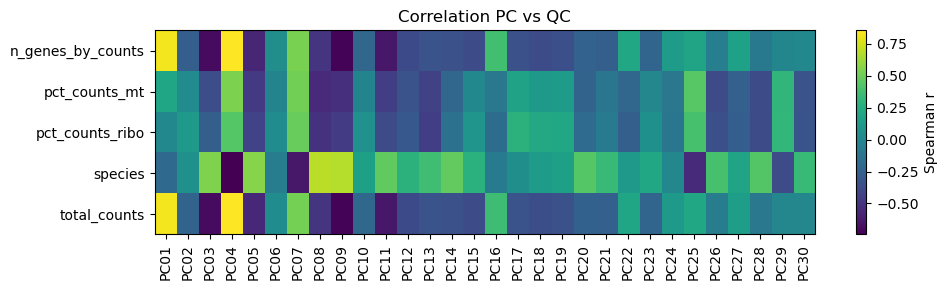

In [26]:
origPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(origPCcorr, save_path=f'pc_qc_correlation_before_harmony{rev_n}.png')

In [27]:
# Mira a los sospechosos
origPCcorr.loc[(origPCcorr["q"] < 0.05) & (origPCcorr["PC"].isin([f"PC{i}" for i in range(1,11)]))].sort_values(["covariate","PC"])

PC          covariate         r              p              q
46  PC10  n_genes_by_counts -0.212664   0.000000e+00   0.000000e+00
47  PC10      pct_counts_mt -0.019991   7.743276e-13   8.237527e-13
48  PC10    pct_counts_ribo  0.065668  9.513461e-123  1.081075e-122
49  PC10            species  0.164516   0.000000e+00   0.000000e+00
45  PC10       total_counts -0.204716   0.000000e+00   0.000000e+00

In [28]:
# PC2 and PC4 looks problematic so I rather delete it
adata_copy = adata.copy() # save backup
#adata.obsm["X_pca"] = np.delete(adata.obsm["X_pca"], [1,3], axis=1) 

In [29]:
#return to this checkpoint
adata = adata_copy.copy()

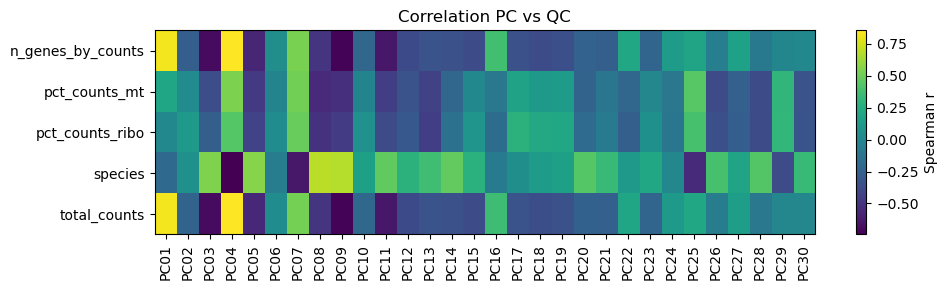

In [30]:
secondPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(secondPCcorr, save_path=f'pc_qc_correlation_pc2_dropped{rev_n}.png')
# just a little improvement

### Harmony Integration

In [31]:
pca_mat = adata.obsm['X_pca']
harmony_out = hm.run_harmony(pca_mat, adata.obs, 'dataset_name', plot_convergence=True)
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T  # check harmonypy return shape; adapt accordingly
# many wrappers exist; alternatively use sc.external.pp.harmony_integrate if available


2025-10-09 14:35:58,536 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-09 14:36:29,892 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-09 14:36:33,640 - harmonypy - INFO - Iteration 1 of 10
2025-10-09 14:37:51,956 - harmonypy - INFO - Iteration 2 of 10
2025-10-09 14:39:05,190 - harmonypy - INFO - Iteration 3 of 10
2025-10-09 14:39:40,558 - harmonypy - INFO - Iteration 4 of 10
2025-10-09 14:40:06,782 - harmonypy - INFO - Iteration 5 of 10
2025-10-09 14:40:35,464 - harmonypy - INFO - Iteration 6 of 10
2025-10-09 14:41:03,365 - harmonypy - INFO - Iteration 7 of 10
2025-10-09 14:41:28,764 - harmonypy - INFO - Iteration 8 of 10
2025-10-09 14:41:53,472 - harmonypy - INFO - Iteration 9 of 10
2025-10-09 14:42:18,544 - harmonypy - INFO - Converged after 9 iterations


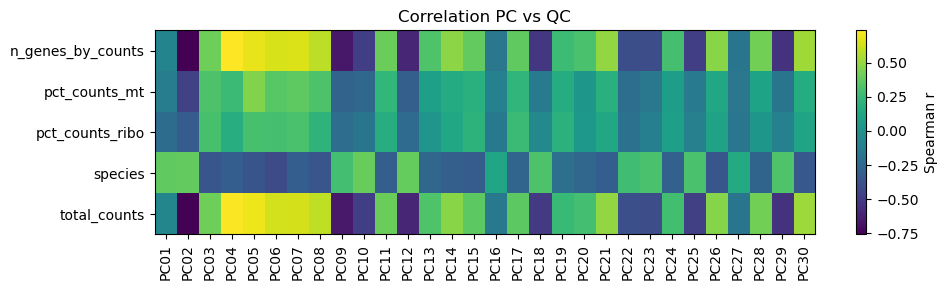

In [32]:
harmonyPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca_harmony")
plot_pc_qc_correlation(harmonyPCcorr, save_path=f'pc_qc_correlation_after_harmony{rev_n}.png')

In [33]:
# sc.pp.combat(adata_hvg, key='dataset_name', inplace=True)
# combat is another type of batch correction, but harmonypy is generally better

### Normalize

In [34]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

### Neighbors
**Small n_neighbors** (e.g. 5–10): 

- Highlights fine-grained local relationships.

- Good for detecting rare cell populations. But can fragment larger, continuous populations into many tiny clusters.

**Large n_neighbors** (e.g. 30–50):

- Incorporates more global structure.

- Produces more coarse and global clusters.

- Good for datasets with strong batch effects (less sensitive to noise). But can miss rare cell types because they get merged into neighbors’ majority.


In [35]:
#Using rule of thumb  for n_neigbors used on neighors
import math
n_cells = adata.shape[0]
n_neighb = int(math.log10(n_cells) * 10)
print(f"Recommended n_neighbors ~ {n_neighb}")

Recommended n_neighbors ~ 51


In [36]:
len(adata.obsm['X_pca_harmony'][0])

50

In [68]:
rep = 'X_pca_harmony'  # use this integrated representation for clustering
sc.pp.neighbors(adata, use_rep=rep, n_neighbors=n_neighb,n_pcs=50)


### Clustering

In [69]:
sc.tl.leiden(adata, resolution=1, key_added='leiden_1.0')


### UMAP

In [70]:
sc.tl.umap(adata, min_dist=0.3) 

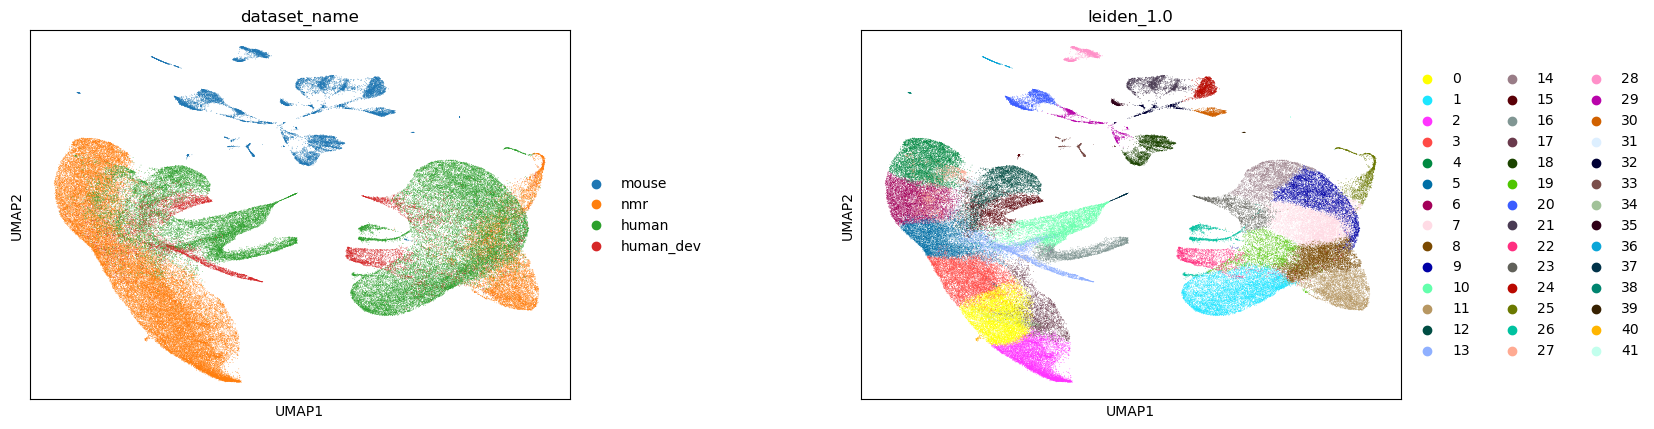

In [71]:
sc.pl.umap(adata, color=['dataset_name', 'leiden_1.0'], wspace=0.4, save=f"_clusters_harmony{rev_n}.png")

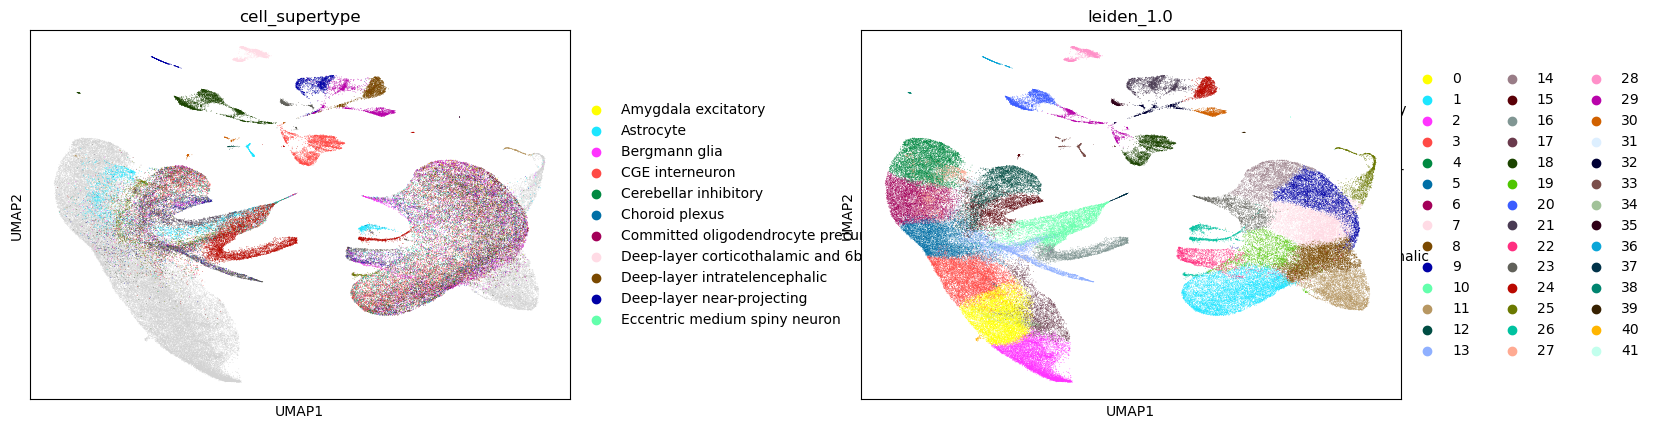

In [72]:
sc.pl.umap(adata, color=['cell_supertype', 'leiden_1.0'], wspace=0.4, save=f"_clusters_harmony_types{rev_n}.png")

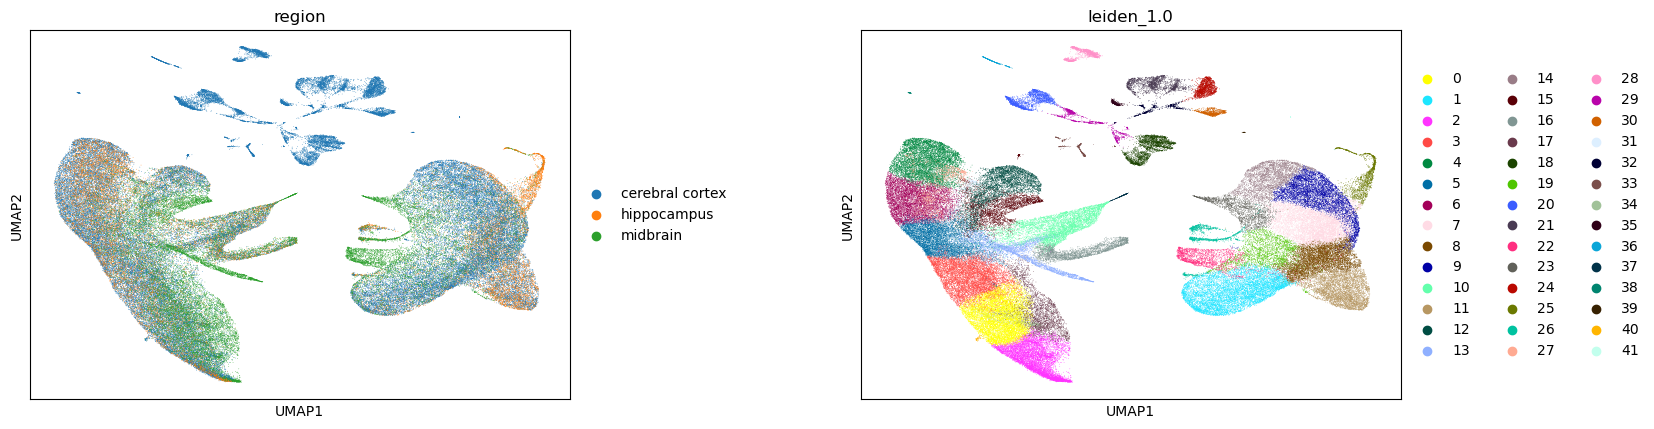

In [73]:
sc.pl.umap(adata, color=['region', 'leiden_1.0'], wspace=0.4, save=f"_clusters_harmony_region{rev_n}.png")

In [99]:
## CHECKPOINT
filename = f'/home/raquelcr/scanpy/integrated_adata_clusters{rev_n}.h5ad'
adata.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/integrated_adata_clusters7.h5ad


In [43]:
!cd /home/raquelcr/scanpy/

#### Don't re-run previous code ;)
(too slow)

In [100]:
try: adata = adata.copy()
except: adata = sc.read(f'/home/raquelcr/scanpy/integrated_adata_clusters{rev_n}.h5ad')

## Metrics calculation

In [101]:
def shannon_entropy_from_counts(counts, base=2):
    """Shannon entropy from a list/array of counts."""
    counts = np.array(counts, dtype=float)
    if counts.sum() == 0:
        return 0.0
    p = counts / counts.sum()
    p = p[p > 0]
    return entropy(p, base=base)

def icc_1way_single_measure(groups, values):
    """
    Compute ICC(1) (one-way random effects) where groups is array-like group id per observation,
    values is numeric value per observation. This implementation follows Shrout & Fleiss formulation.
    Returns ICC(1) estimate. If degenerate, returns np.nan.
    """
    groups = np.asarray(groups)
    values = np.asarray(values, dtype=float)
    unique_g = np.unique(groups)
    k = len(unique_g)
    if k < 2:
        return np.nan
    # per-group stats
    n_i = np.array([np.sum(groups == g) for g in unique_g])
    mean_i = np.array([values[groups == g].mean() for g in unique_g])
    N = len(values)
    mean_all = values.mean()
    # Mean squares between and within
    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)
    ss_within = np.sum([(values[groups == g] - values[groups == g].mean()) ** 2 for g in unique_g])
    ms_within = ss_within / (N - k) if N > k else 0.0
    denom = ms_between + (n_i.mean() - 1) * ms_within
    if denom == 0:
        return np.nan
    icc = (ms_between - ms_within) / denom
    return float(icc)


In [102]:
def icc_1way_single_measure(groups, values):
    """
    One-way random effects ICC(1,1).
    groups: array of group labels
    values: array of numeric values
    """
    groups = np.array(groups)
    values = np.array(values, dtype=float)
    unique_g = np.unique(groups)

    N = len(values)
    k = len(unique_g)
    n_i = np.array([np.sum(groups == g) for g in unique_g])

    mean_all = np.mean(values)
    mean_i = np.array([np.mean(values[groups == g]) for g in unique_g])

    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)

    ss_within = sum(
        np.sum((values[groups == g] - values[groups == g].mean()) ** 2)
        for g in unique_g
    )
    ms_within = ss_within / (N - k) if N > k else 0.0

    denom = ms_between + (n_i.mean() - 1) * ms_within
    icc = (ms_between - ms_within) / denom if denom > 0 else 0.0
    return icc


In [103]:
def compute_cluster_metrics(adata,
                            species_col='species',
                            cluster_col='cluster',
                            ann_col='annotation',
                            species_list=('human', 'mouse', 'nmr')):
    """
    Returns a pandas DataFrame with metrics per cluster.
    """
    obs = adata.obs.copy()
    # ensure cluster col is string-like
    obs['_cluster_str'] = obs[cluster_col].astype(str)
    clusters = obs['_cluster_str'].unique()
    rows = []
    for cl in sorted(clusters, key=lambda x: (float(x) if x.replace('.','',1).isdigit() else x)):
        sub = obs[obs['_cluster_str'] == cl]
        n_cells = len(sub)
        # pct not annotated (cells where ann_col is NA / empty)
        not_ann = sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == '')
        pct_not_annotated = not_ann.sum() / max(1, n_cells)
        # species mix entropy
        species_counts = sub[species_col].value_counts()
        # make sure we compute entropy over species_list order if provided
        species_counts_list = [species_counts.get(s, 0) for s in species_list]
        ent_species = shannon_entropy_from_counts(species_counts_list, base=2)
        # ICC: here we compute ICC of "species label as numeric group" on a dummy numeric vector (1s),
        # but that's meaningless. A better practical ICC for per-cluster species homogeneity:
        # compute ICC of a binary indicator per species across annotated identities:
        # instead compute ICC of species fraction across per-cell one-hot for species groups.
        # Implementation: for this cluster, create groups = species, values = 1 for each cell,
        # then ICC is computed across species groups — this effectively measures between-group variance.
        # (This is a proxy; you can replace with another continuous metric if preferred.)
        groups = sub[species_col].values
        values = np.ones(len(sub))
        icc_sp = icc_1way_single_measure(groups, values)
        # For human and mouse majority annotation within cluster:
        info = {'cluster': cl, 'n_cells': n_cells,
                'pct_not_annotated': pct_not_annotated,
                'shannon_entropy_species': ent_species,
                'icc_species_fraction': icc_sp}
        for sp in ['human', 'mouse']:
            sub_sp = sub[sub[species_col] == sp]
            if len(sub_sp) == 0:
                info[f'{sp}_majority_annotation'] = np.nan
                info[f'{sp}_majority_frac'] = np.nan
            else:
                # among these, consider only annotated cells
                ann_counts = sub_sp[~(sub_sp[ann_col].isna() | (sub_sp[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
                if ann_counts.sum() == 0:
                    info[f'{sp}_majority_annotation'] = np.nan
                    info[f'{sp}_majority_frac'] = 0.0
                else:
                    maj_ann = ann_counts.idxmax()
                    maj_frac = ann_counts.loc[maj_ann] / ann_counts.sum()
                    info[f'{sp}_majority_annotation'] = maj_ann
                    info[f'{sp}_majority_frac'] = float(maj_frac)
        # global majority among annotated cells in cluster
        ann_counts_global = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts_global.sum() == 0:
            info['global_majority_annotation'] = np.nan
            info['global_majority_frac'] = 0.0
        else:
            gmaj = ann_counts_global.idxmax()
            info['global_majority_annotation'] = gmaj
            info['global_majority_frac'] = float(ann_counts_global.loc[gmaj] / ann_counts_global.sum())
        rows.append(info)
    cluster_metrics = pd.DataFrame(rows).set_index('cluster')
    return cluster_metrics


In [104]:
def assign_cluster_majority(adata, cluster_metrics, ann_col='annotation', cluster_col='cluster'):
    """Add predicted annotation to adata.obs as 'predicted_annotation' based on cluster global majority."""
    obs = adata.obs
    # map cluster -> global_majority_annotation
    mapping = cluster_metrics['global_majority_annotation'].to_dict()
    obs['predicted_annotation'] = obs[cluster_col].astype(str).map(mapping).astype(object)
    # leave as NaN where mapping missing
    return None  # adata modified in place

In [105]:
# Pipeline for cross-species cluster-based annotation + metrics

def cross_validate_cluster_majority(adata,
                                    ann_col='annotation',
                                    species_col='species',
                                    cluster_col='cluster',
                                    species_to_mask=('human', 'mouse'),
                                    test_fraction=0.2,
                                    random_state=0):
    """
    For each species in species_to_mask:
      - stratify by annotation (if enough cells) and select test_fraction to hide
    Then: compute cluster majority using remaining labels and predict on held-out labels.
    Returns accuracy, confusion matrix and the indices of test cells.
    """
    obs = adata.obs.copy()
    # get indices for candidates (human+mouse annotated)
    candidates = obs[obs[species_col].isin(species_to_mask)].copy()
    # ensure annotated
    candidates = candidates[~(candidates[ann_col].isna() | (candidates[ann_col].astype(str).str.strip() == ''))]
    if candidates.empty:
        raise ValueError("No annotated human/mouse cells found for cross-validation.")
    test_idx = []
    train_mask = pd.Series(True, index=obs.index)
    # stratify within each species separately
    for sp in species_to_mask:
        sp_idx = candidates[candidates[species_col] == sp].index
        if len(sp_idx) == 0:
            continue
        y = candidates.loc[sp_idx, ann_col].values
        # if number of unique classes small or counts small, train_test_split stratify might fail.
        try:
            train_i, test_i = train_test_split(sp_idx, test_size=test_fraction, stratify=y, random_state=random_state)
        except Exception:
            # fallback: random sample
            test_i = np.random.RandomState(random_state).choice(sp_idx, size=max(1, int(len(sp_idx)*test_fraction)), replace=False)
            train_i = [i for i in sp_idx if i not in test_i]
        test_idx.extend(list(test_i))
        # mark those as hidden for training
        train_mask.loc[test_i] = False
    # create a copy of annotations for training where we mask test_idx
    obs_train = obs.copy()
    obs_train.loc[test_idx, ann_col] = np.nan
    # compute cluster majority from obs_train
    # build cluster -> majority annotation across all annotated cells in cluster (human+mouse+other if present)
    cluster_majority = {}
    for cl, sub in obs_train.groupby(cluster_col):
        ann_counts = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts.sum() == 0:
            cluster_majority[cl] = np.nan
        else:
            cluster_majority[cl] = ann_counts.idxmax()
    # predictions for test cells
    y_true = obs.loc[test_idx, ann_col].values
    y_pred = [cluster_majority.get(cl, np.nan) for cl in obs.loc[test_idx, cluster_col].astype(str).values]
    # compute accuracy (ignore nan predictions if they occur)
    mask_valid = pd.Series(y_pred).notna().values
    if mask_valid.sum() == 0:
        acc = np.nan
    else:
        acc = accuracy_score(np.array(y_true)[mask_valid], np.array(y_pred)[mask_valid])
    # confusion matrix across classes that appear in true set (will include only predicted ones for which mapping exists)
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, pd.Series(y_pred), labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return {'accuracy': float(acc) if not np.isnan(acc) else np.nan,
            'confusion_matrix': cm_df,
            'n_test': len(test_idx),
            'test_idx': test_idx,
            'cluster_majority_from_train': cluster_majority}



In [106]:
leiden_res = 'leiden_1.0'
cluster_metrics = compute_cluster_metrics(adata, species_col='species', cluster_col=leiden_res, ann_col='cell_supertype')
print(cluster_metrics.head())
assign_cluster_majority(adata, cluster_metrics, ann_col='cell_supertype', cluster_col=leiden_res)
cv_results = cross_validate_cluster_majority(adata, ann_col='cell_supertype', cluster_col=leiden_res, species_col='species')
print("CV accuracy:", cv_results['accuracy'])
print("Confusion matrix:\n", cv_results['confusion_matrix'])
cluster_metrics.to_csv('/home/raquelcr/scanpy/harmony_cluster_metrics.csv')

         n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0           8913           0.996746                 0.031574   
1           8539           0.003162                 0.030815   
2           8112           0.999753                 0.003311   
3           7857           0.952654                 0.275016   
4           6855           0.988038                 0.093536   

         icc_species_fraction  human_majority_annotation  human_majority_frac  \
cluster                                                                         
0                         0.0  Oligodendrocyte precursor             0.310345   
1                         0.0            CGE interneuron             0.215578   
2                         0.0  LAMP5-LHX6 and Chandelier             0.500000   
3                         0.0              Miscellaneous             0.276882   
4                         0.0                  Astrocyte         

In [107]:
adata.obs

label  sizeFactor subclass   n_counts species  \
F1S4_160108_001_A01          Vip    1.085313      Vip  1730700.0   mouse   
F1S4_160108_001_B01        Lamp5    1.197503    Lamp5  1909605.0   mouse   
F1S4_160108_001_C01        Lamp5    1.244751    Lamp5  1984948.0   mouse   
F1S4_160108_001_D01          Vip    1.437020      Vip  2291552.0   mouse   
F1S4_160108_001_E01        Lamp5    1.102096    Lamp5  1757463.0   mouse   
...                          ...         ...      ...        ...     ...   
10X122_8:GTCATTTAGGAGTTTA    NaN         NaN      NaN        NaN   human   
10X122_8:CGTCTACTCAGCAACT    NaN         NaN      NaN        NaN   human   
10X122_7:AGAGCGATCGGCGCAT    NaN         NaN      NaN        NaN   human   
10X122_8:TTATGCTAGAGCCCAA    NaN         NaN      NaN        NaN   human   
10X122_8:AGACGTTGTTTCGCTC    NaN         NaN      NaN        NaN   human   

                          cell_type   cell_supertype     dissection  \
F1S4_160108_001_A01         CGE_276  CGE interneuron  Visual Cortex   
F1S4_160108_001_B01         CGE_277  CGE interneuron  Visual Cortex   
F1S4_160108_001_C01         CGE_277  CGE interneuron  Visual Cortex   
F1S4_160108_001_D01         CGE_276  CGE interneuron  Visual Cortex   
F1S4_160108_001_E01         CGE_277  CGE interneuron  Visual Cortex   
...                             ...              ...            ...   
10X122_8:GTCATTTAGGAGTTTA    Bgl_51    Bergmann glia  Mesencephalon   
10X122_8:CGTCTACTCAGCAACT    Bgl_51    Bergmann glia  Mesencephalon   
10X122_7:AGAGCGATCGGCGCAT    Bgl_51    Bergmann glia  Mesencephalon   
10X122_8:TTATGCTAGAGCCCAA    Bgl_51    Bergmann glia  Mesencephalon   
10X122_8:AGACGTTGTTTCGCTC    Bgl_51    Bergmann glia  Mesencephalon   

                                    region  n_genes_by_counts  ...  \
F1S4_160108_001_A01        cerebral cortex               9029  ...   
F1S4_160108_001_B01        cerebral cortex              10207  ...   
F1S4_160108_001_C01        cerebral cortex              10578  ...   
F1S4_160108_001_D01        cerebral cortex               8482  ...   
F1S4_160108_001_E01        cerebral cortex               8697  ...   
...                                    ...                ...  ...   
10X122_8:GTCATTTAGGAGTTTA         midbrain               1402  ...   
10X122_8:CGTCTACTCAGCAACT         midbrain                883  ...   
10X122_7:AGAGCGATCGGCGCAT         midbrain                994  ...   
10X122_8:TTATGCTAGAGCCCAA         midbrain                848  ...   
10X122_8:AGACGTTGTTTCGCTC         midbrain                809  ...   

                           tissue_type  tissue_ontology_term_id  \
F1S4_160108_001_A01                NaN                      NaN   
F1S4_160108_001_B01                NaN                      NaN   
F1S4_160108_001_C01                NaN                      NaN   
F1S4_160108_001_D01                NaN                      NaN   
F1S4_160108_001_E01                NaN                      NaN   
...                                ...                      ...   
10X122_8:GTCATTTAGGAGTTTA       tissue           UBERON:0001891   
10X122_8:CGTCTACTCAGCAACT       tissue           UBERON:0001891   
10X122_7:AGAGCGATCGGCGCAT       tissue           UBERON:0001891   
10X122_8:TTATGCTAGAGCCCAA       tissue           UBERON:0001891   
10X122_8:AGACGTTGTTTCGCTC       tissue           UBERON:0001891   

                           cell_type_ontology_term_id  fraction_mitochondrial  \
F1S4_160108_001_A01                               NaN                     NaN   
F1S4_160108_001_B01                               NaN                     NaN   
F1S4_160108_001_C01                               NaN                     NaN   
F1S4_160108_001_D01                               NaN                     NaN   
F1S4_160108_001_E01                               NaN                     NaN   
...                                               ...                     ...   
10X122_8:GTCATTTAGGAGTTTA                  CL:00

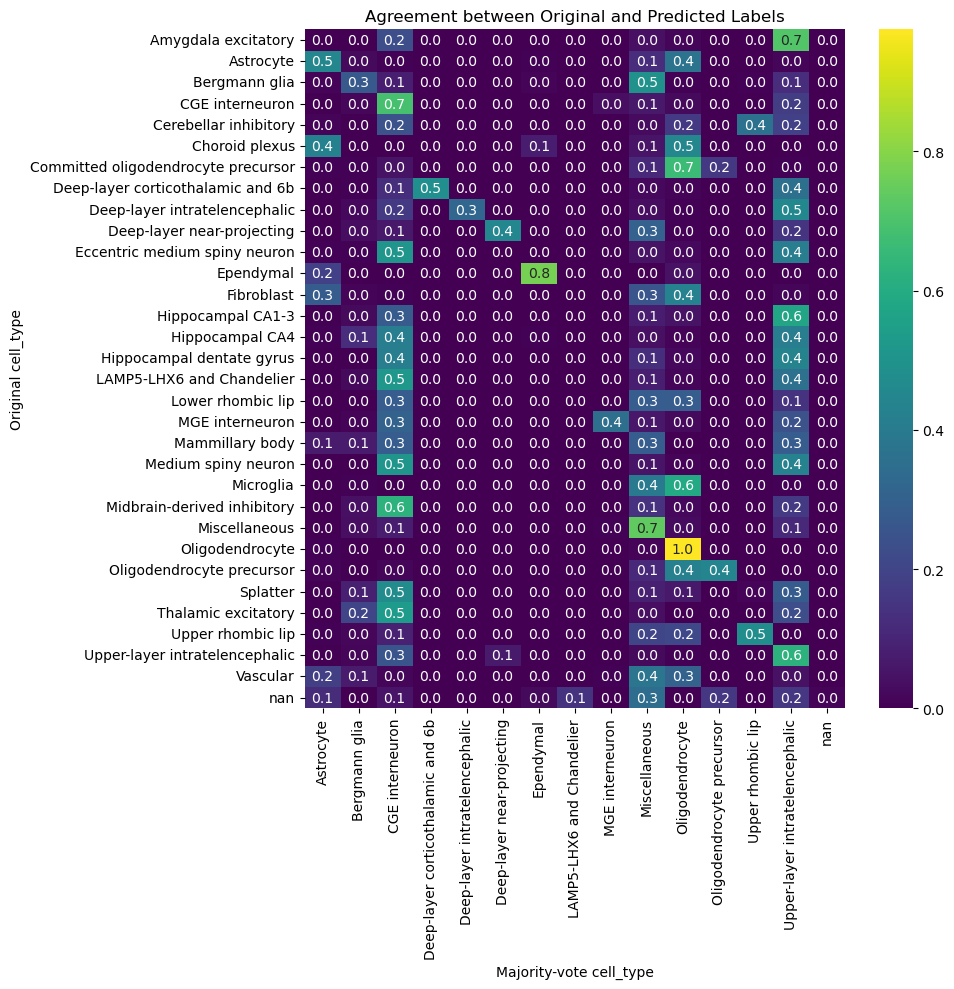

In [108]:
# Build confusion matrix
true_labels = adata.obs["cell_supertype"].astype(str)
pred_labels = adata.obs["predicted_annotation"].astype(str)

cm = pd.crosstab(true_labels, pred_labels, rownames=["Original"], colnames=["Majority-vote"])

# Normalize rows (fractions per original label, easier to read)
cm_norm = cm.div(cm.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis")
plt.title("Agreement between Original and Predicted Labels")
plt.ylabel("Original cell_type")
plt.xlabel("Majority-vote cell_type")
plt.tight_layout()
plt.show()

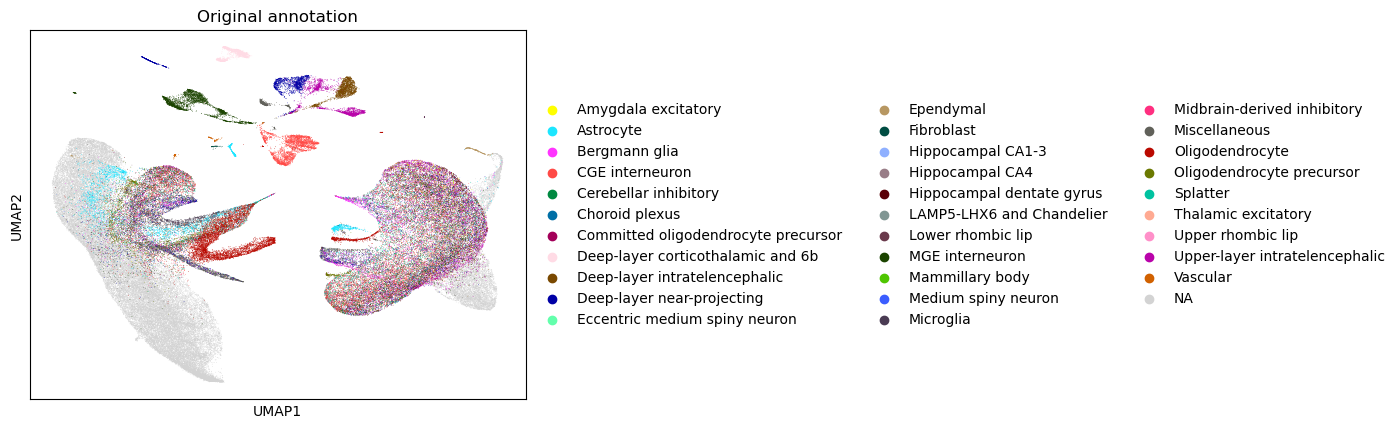

In [109]:
# Plot side by side
sc.pl.umap(
    adata,
    color="cell_supertype",
    title="Original annotation"
)

In [110]:
adata.obs.columns

Index(['label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type',
       'cell_supertype', 'dissection', 'region', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'tissue', 'sample_id', 'replicate', 'sample', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'total_UMIs', 'cluster_id', 'roi', 'Age',
       'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type',
       'tissue_ontology_term_id', 'cell_type_ontology_term_id',


In [111]:
adata.obs['dataset_name'][adata.obs['Tissue'].notna()]

10X175_8:TGCTCCAGTTGTGTAC    human
10X182_1:AAGAACAAGCCAACCC    human
10X173_4:TGAACGTCACCAAAGG    human
10X176_1:ACCATTTAGCACGATG    human
10X376_8:GAATCGTTCGATACGT    human
                             ...  
10X276_7:AGCGCCACACATTCTT    human
10X249_8:AGACACTAGCATCAGG    human
10X387_6:TTTCACACACAAGGTG    human
10X379_5:TTCTTCCCATACAGCT    human
10X392_1:AGCGCTGAGGTTGTTC    human
Name: dataset_name, Length: 48406, dtype: category
Categories (4, object): ['mouse', 'nmr', 'human', 'human_dev']

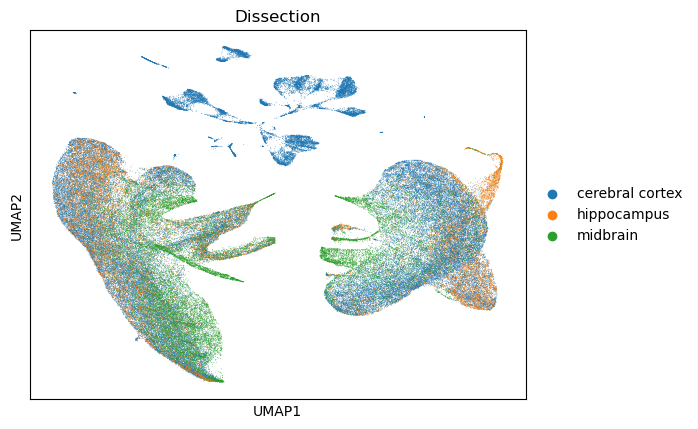

In [112]:
# Plot side by side
sc.pl.umap(
    adata,
    color="region",
    title="Dissection"
)

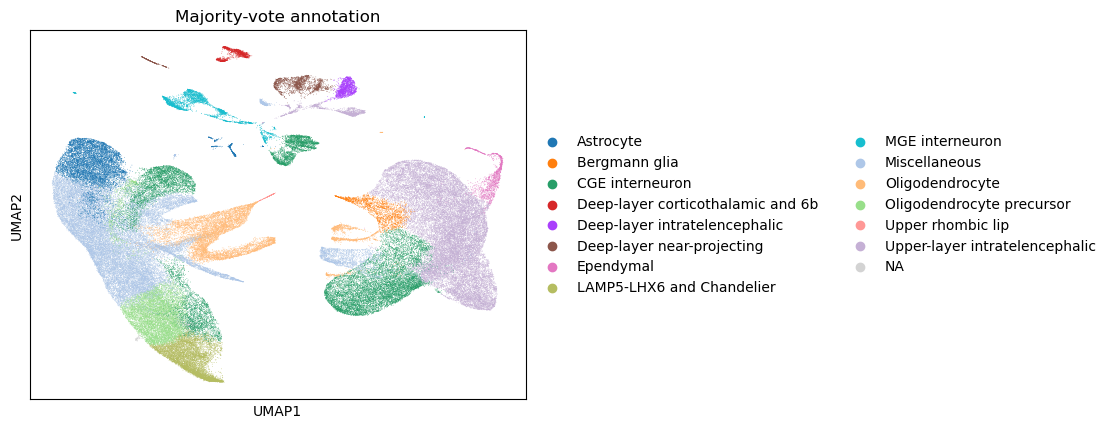

In [113]:
# Plot side by side
sc.pl.umap(
    adata,
    color="predicted_annotation",
    title="Majority-vote annotation"
)

In [114]:
nmr_data = adata[adata.obs['species'] == 'nmr'].copy()

In [115]:
cortex = nmr_data[nmr_data.obs['tissue'] == 'cerebral_cortex'].copy()
hippocampus = nmr_data[nmr_data.obs['tissue'] == 'hippocampus'].copy()
midbrain = nmr_data[nmr_data.obs['tissue'] == 'cerebral_cortex'].copy()

In [116]:
tissue_list = [cortex, hippocampus, midbrain]

<Axes: title={'center': 'Only NMR predicted annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

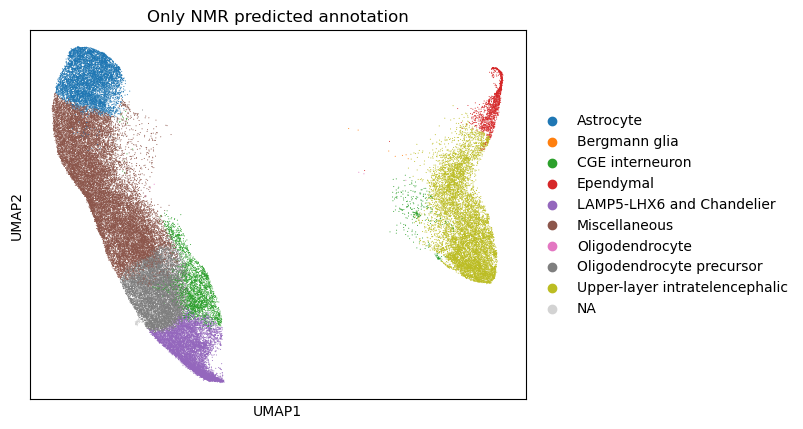

In [118]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    show=False,
    title="Only NMR predicted annotation"
)

<Axes: title={'center': 'Only NMR by tissue'}, xlabel='UMAP1', ylabel='UMAP2'>

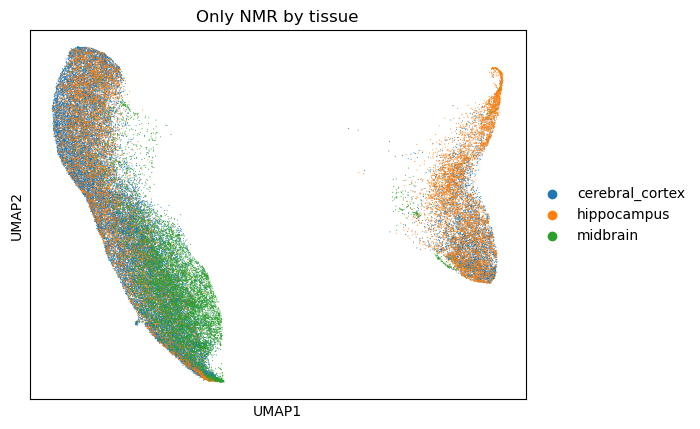

In [119]:
sc.pl.umap(
    adata[adata.obs['species'] == 'nmr'],
    color="tissue",
    show=False,
    title="Only NMR by tissue"
)


In [ ]:
# Calculate total counts per gene
gene_sums = np.array(nmr_data.X.sum(axis=0)).ravel()

# Filter genes that have nonzero expression
nmr_data = nmr_data[:, gene_sums > 0]

print(f"Remaining genes: {nmr_data.n_vars}")

In [122]:
sc.pp.pca(nmr_data, svd_solver='arpack')
sc.pp.neighbors(nmr_data, n_neighbors=15, n_pcs=40)
sc.tl.umap(nmr_data)


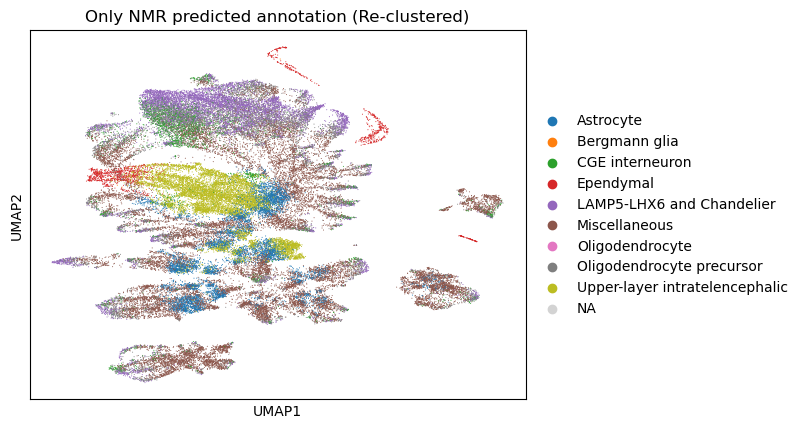

In [123]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    title="Only NMR predicted annotation (Re-clustered)",
    save=f'_nmr_predicted{rev_n}.png')

In [124]:
nmr_data.obs['predicted_annotation'].value_counts()

predicted_annotation
Miscellaneous                     19676
Oligodendrocyte precursor          8895
Upper-layer intratelencephalic     8786
LAMP5-LHX6 and Chandelier          8110
Astrocyte                          6857
CGE interneuron                    2877
Ependymal                          1355
Bergmann glia                         7
Oligodendrocyte                       6
Name: count, dtype: int64

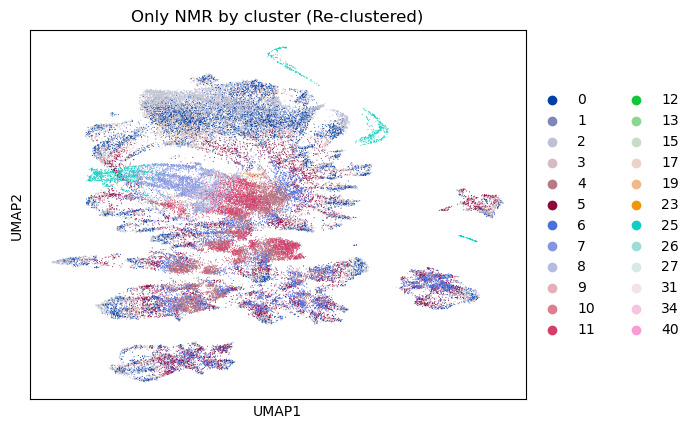

In [125]:
sc.pl.umap(
    nmr_data,
    color=leiden_res,
    title="Only NMR by cluster (Re-clustered)",
    save= f'_nmr_clusters{rev_n}.png'
)

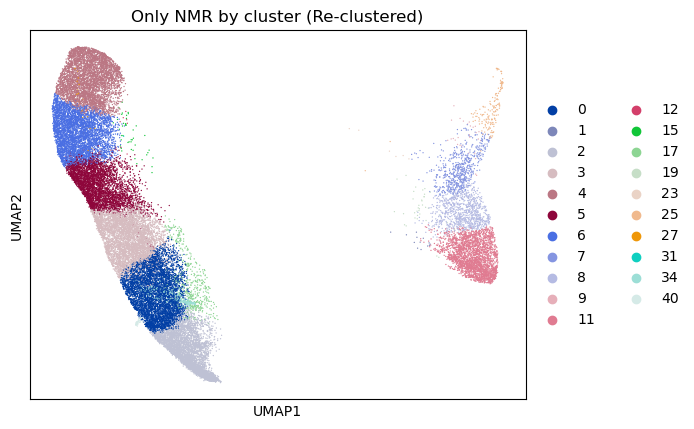

In [126]:
sc.pl.umap(
    cortex,
    color=leiden_res,
    title="Only NMR by cluster (Re-clustered)"
)

<Axes: title={'center': 'Only NMR by tissue (Re-clustered)'}, xlabel='UMAP1', ylabel='UMAP2'>

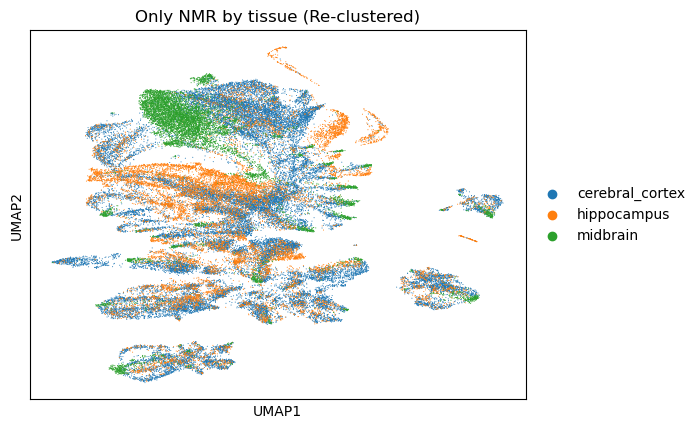

In [127]:
sc.pl.umap(
    nmr_data,
    color="tissue",
    show=False,
    title="Only NMR by tissue (Re-clustered)"
)

In [128]:
nmr_data.obs.columns

Index(['label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type',
       'cell_supertype', 'dissection', 'region', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'tissue', 'sample_id', 'replicate', 'sample', 'Tissue', 'TotalUMIs',
       'organism_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id',
       'sex_ontology_term_id', 'development_stage_ontology_term_id',
       'donor_id', 'suspension_type', 'total_UMIs', 'cluster_id', 'roi', 'Age',
       'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type',
       'tissue_ontology_term_id', 'cell_type_ontology_term_id',


<Axes: title={'center': 'Only NMR (corteza)'}, xlabel='UMAP1', ylabel='UMAP2'>

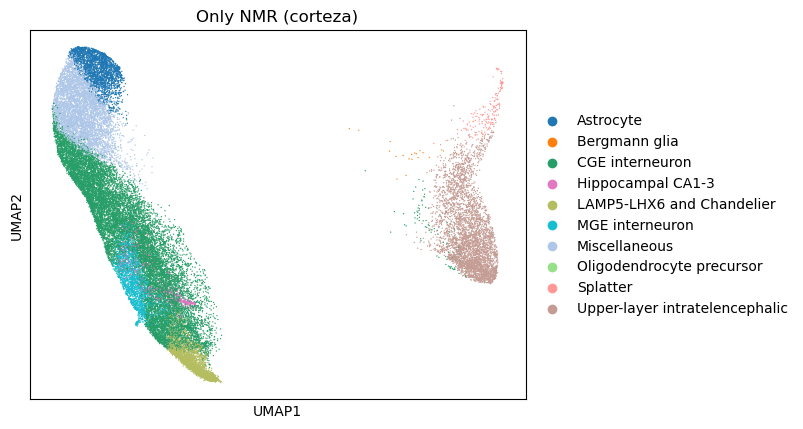

In [ ]:
sc.pl.umap(
    cortex,
    color="predicted_annotation",
    title="Only NMR (corteza)"
)

In [97]:
cortex.obs['predicted_annotation'].value_counts()

predicted_annotation
CGE interneuron                   15406
Miscellaneous                      5445
Upper-layer intratelencephalic     4227
LAMP5-LHX6 and Chandelier          3033
Astrocyte                          2479
MGE interneuron                    2109
Hippocampal CA1-3                   629
Splatter                            178
Bergmann glia                        20
Oligodendrocyte precursor             2
Name: count, dtype: int64

In [136]:
# Save object
filename= f'/home/raquelcr/scanpy/final_nmr_crossAnn{rev_n}.h5ad'
sc.write(filename, nmr_data)
print(f'Succesfully saved on {filename}')

Succesfully saved on /home/raquelcr/scanpy/final_nmr_crossAnn7.h5ad


In [137]:
!du -h $filename

4.1G	/home/raquelcr/scanpy/final_nmr_crossAnn7.h5ad


In [138]:
!du -h '/home/raquelcr/scanpy/integrated_adata_clusters7.h5ad'

9.9G	/home/raquelcr/scanpy/integrated_adata_clusters7.h5ad
